### Improving Parking Meter Revenue by Prioritizing Street Maintinence Requests

My original goal for this project was to determine if street maintinence affects the revenue of parking meters. This idea came from my own experience parking in San Diego, dodging construction zones and avoiding potholes. My approach was to use geospatial methods to combine the meter locations and maintinence requests using a proximity buffer. From there I was able to determine meter revenue before and after the maitenence request was closed. I used the difference between the pre and post revenues to create a categorical priority system. I used a Hypothesis Test using the bootstrap to determine which maintinence request types were most valueable to be completed first. Lastly I trained some machine learning models to predict 

My datasets originated from San Diego's open data portal, links to datasets can be found below.

Parking Meter Locations: https://data.sandiego.gov/datasets/parking-meters-locations/
Parking Meter Transactions: https://data.sandiego.gov/datasets/parking-meters-transactions/
Get It Done Applications(Maintinence Requests): https://data.sandiego.gov/datasets/get-it-done-311/

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from datetime import datetime
from datetime import timedelta
import zipfile
import folium
import json
import joblib
import pyodbc

In [2]:
import os

In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

In [4]:
with zipfile.ZipFile("data/cleared.zip",mode="r") as cleared_ref:
    cleared_ref.extractall()
    
with zipfile.ZipFile("data/parking_payments.zip",mode="r") as payment_ref:
    payment_ref.extractall()
    
COLOR_M = '#702963'#main color
COLOR_F = '#F2F2F2' #background color

In [5]:
cleared_raw = pd.read_csv('cleared.csv', low_memory=False)
meter_raw = pd.read_csv('data/parking_meters.csv')
payment_raw = pd.read_csv('parking_payments.csv')

In [6]:
#This dataset contains incidents that have already been resolved. 
#This will be our training/testing data
cleared_raw.head()

,service_request_id,service_request_parent_id,sap_notification_number,date_requested,case_age_days,case_record_type,service_name,service_name_detail,date_closed,status,...,zipcode,council_district,comm_plan_code,comm_plan_name,park_name,case_origin,referred,iamfloc,floc,public_description
0,100123,NaN,4.030000e+10,2016-08-17T16:40:00,1654.0,TSW,Pavement Maintenance,CONCRETE PAVEMENT REPAIR ISSUE,2021-02-26,Closed,...,NaN,5.0,31.0,Rancho Bernardo,NaN,Web,NaN,SS-020515-PV1,SS-020515,We have a cement street it is buckling and one...
1,100191,87204.0,NaN,2016-08-17T23:48:00,1842.0,TSW,Pavement Maintenance,Evaluate for Resurfacing/Slurry,2021-09-02,Closed,...,NaN,5.0,3.0,Carmel Mountain Ranch,NaN,Web,NaN,NaN,SS-022700,Potholes and uneven pavement throughout Rancho...
2,100194,NaN,4.030001e+10,2016-08-18T04:17:00,1652.0,TSW,Pavement Maintenance,DAMAGED CURB,2021-02-25,Closed,...,NaN,2.0,6.0,Clairemont Mesa,NaN,Web,NaN,SS-014744-PV1,SS-014744,"curb cracked, please fill\ngutter joint depres..."
3,100241,NaN,4.030001e+10,2016-08-18T09:23:00,1751.0,TSW,Stormwater,DRAIN INLET,2021-06-04,Closed,...,NaN,7.0,19.0,Mission Valley,NaN,Email,NaN,IN22626,43802117,BRUSH AND OTHER DEBRIS IN DRAIN - REQUEST REMOVAL
4,100867,NaN,4.030000e+10,2016-08-21T12:19:00,1838.0,TSW,Pavement Maintenance,EVALUATE FOR RESURFACING/SLURRY,2021-09-02,Closed,...,NaN,9.0,57.0,Mid-City:Eastern Area,NaN,Mobile,NaN,SS-026868-PV1,SS-026868,This road needs To be repaired immediately


In [8]:
#This dataset contains the locatins for parking meters
meter_raw.head()

,zone,area,sub_area,pole,config_id,config_name,date_inventory,lat,lng,sapid
0,Downtown,Core,1000 FIRST AVE,1-1004,49382,Sunday Mode,2021-01-04,32.715904,-117.163929,SS-000031
1,Downtown,Core - Columbia,1000 FIRST AVE,1-1004,9000,2 Hour Max $1.25 HR 8am-6pm Mon-Sat (NFC),2018-11-11,32.715904,-117.163929,SS-000031
2,Downtown,Core,1000 FIRST AVE,1-1006,49382,Sunday Mode,2021-01-04,32.716037,-117.163930,SS-000031
3,Downtown,Core - Columbia,1000 FIRST AVE,1-1006,9000,2 Hour Max $1.25 HR 8am-6pm Mon-Sat (NFC),2018-11-11,32.716037,-117.163930,SS-000031
4,Downtown,Core,1000 FIRST AVE,1-1008,49382,Sunday Mode,2021-01-04,32.716169,-117.163931,SS-000031


In [9]:
#This dataset contains the actual transactions for each parking meter.
#This is by far the largest dataset to work with
payment_raw.head()

,pole_id,meter_type,date_trans_start,date_meter_expire,trans_amt,pay_method
0,M-4203,SS,2021-01-01 02:46:42,2021-01-01 02:46:42,45,CASH
1,M-4203,SS,2021-01-01 02:46:50,2021-01-01 02:46:50,10,CASH
2,M-4203,SS,2021-01-01 02:47:01,2021-01-01 02:47:01,10,CASH
3,WF-300N,SS,2021-01-01 06:09:51,2021-01-01 10:00:19,250,CREDIT CARD
4,KT-800W,SS,2021-01-01 06:19:19,2021-01-01 11:40:18,275,CREDIT CARD


In [10]:
#The first thing that stood out to me was that there was no delta time for each transaction, easy fix
to_datetime = lambda x: datetime.fromisoformat(x)
payment_raw.date_trans_start = payment_raw.date_trans_start.apply(to_datetime)
payment_raw.date_meter_expire = payment_raw.date_meter_expire.apply(to_datetime)

payment_raw['time'] = payment_raw.date_meter_expire - payment_raw.date_trans_start


In [11]:
payment_raw.time.sort_values()

0         0 days 00:00:00
3038123   0 days 00:00:00
3038118   0 days 00:00:00
3038112   0 days 00:00:00
3038109   0 days 00:00:00
                ...      
4759817   0 days 10:59:49
3622820   0 days 10:59:49
1416666   0 days 10:59:50
1694681   0 days 10:59:55
2554839   0 days 16:55:31
Name: time, Length: 5313455, dtype: timedelta64[ns]

In [12]:
#drop transactions for zero time
zero_payment = payment_raw[payment_raw.time <= timedelta()].index
payment_raw.drop(zero_payment, inplace=True)
#Parking meters are only active Mon-Sat meaning 'Sunday Mode' meters are duplicates
#drop Sunday Mode meters
sunday_meters = meter_raw[meter_raw.config_name == 'Sunday Mode'].index
meter_raw.drop(sunday_meters, inplace=True)

In [14]:
graph_1_data = cleared_raw.service_name.value_counts()
graph_1_cols = graph_1_data.index[0:8]
other_count = graph_1_data.drop(graph_1_cols).sum()
graph_1_data['Other'] = other_count


graph_1_data = graph_1_data.loc[graph_1_cols]


graph_1_style = {
    'kind':'barh',
    'figsize':(10,10),
    'fontsize':14,
    'color':COLOR_M    
}

Illegal Dumping                            58198
Parking                                    52496
Missed Collection                          43319
Graffiti                                   36752
Encampment                                 36583
Shared Mobility Device                     28052
Pothole                                    13352
Other                                      79315
Street Light Maintenance                    9247
Tree Maintenance                            8910
Traffic Signal Issue                        6038
Environmental Services Code Compliance      5342
Graffiti - Code Enforcement                 5181
Traffic Sign Maintenance                    4638
Sidewalk Repair Issue                       4319
Dead Animal                                 4120
Pavement Maintenance                        3690
ROW Maintenance                             3554
Stormwater Code Enforcement                 3445
Traffic Signal Timing                       3278
Trash/Recycling Coll

<AxesSubplot:title={'center':'Most Common Request Types'}, xlabel='Number of Requests'>

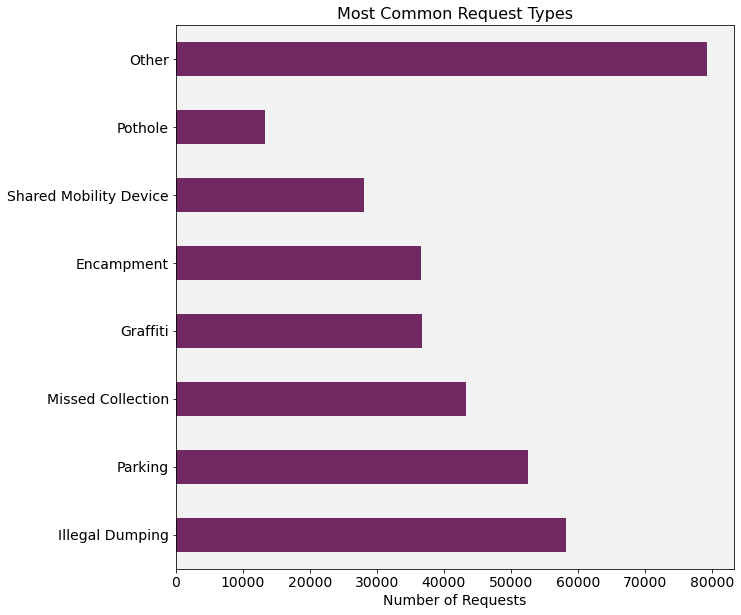

In [15]:
graph_1 = graph_1_data.plot(**graph_1_style)
graph_1.set_facecolor(COLOR_F)
graph_1.set_xlabel('Number of Requests', fontsize=14)
graph_1.set_title('Most Common Request Types', fontsize=16)

graph_1

In [17]:
#add geometry and determine CRS, switch to projected CRS for accurate distance measurements
meter_df = gpd.GeoDataFrame(meter_raw, geometry=gpd.points_from_xy(meter_raw.lng, meter_raw.lat), crs='EPSG:4326').to_crs(epsg=3857)
cleared_df = gpd.GeoDataFrame(cleared_raw, geometry=gpd.points_from_xy(cleared_raw.lng, cleared_raw.lat),crs='EPSG:4326').to_crs(epsg=3857)

In [18]:
ZIPS = 'spatial/zips.geojson'
zip_gdf = gpd.read_file(ZIPS).to_crs(epsg=3857)

#get only zipcodes that have a meter
meter_zips = zip_gdf.sjoin(meter_df, how='inner')
#get zipcodes that have a meter and a resolved GID request
cleared_zips = zip_gdf.loc[meter_zips.index.unique(),:].sjoin(cleared_df, how='inner')

In [19]:
#only keep incidents in zip codes where there are parking meters
#meter data is restricted to specific zip codes
VALID_METERS = meter_zips.index_right
meter_df = meter_df.loc[VALID_METERS]
VALID_CLEARED = cleared_zips.index_right
cleared_df = cleared_df.loc[VALID_CLEARED]

POPULATED_ZIPS = cleared_zips.index


In [20]:
def fix_date(datestr):
    if pd.isna(datestr):
        return np.nan
    year, month, day = datestr.split('-')
    return datetime(int(year), int(month), int(day))

In [21]:
meter_buffer = meter_df.copy()
meter_buffer.geometry = meter_df.buffer(50) #buffer of 50 meters
valid_cleared = cleared_df.sjoin(meter_buffer,how='inner')
valid_cleared.reset_index(drop=True,inplace=True)
valid_cleared.date_closed = valid_cleared.date_closed.apply(fix_date).dropna()

In [22]:
zip_gdf_active = gpd.GeoSeries(zip_gdf.loc[POPULATED_ZIPS].groupby('ZIP').apply(lambda x: x.geometry.iloc[0]), crs='EPSG:3857')

#Here I switch back to a geodesic CRS because I will use this data to create a map
#A geodesic CRS will have more accurate positions than a projected CRS
zip_gjson = zip_gdf.geometry.to_crs('EPSG:4326').to_json()
zip_gjson_active = zip_gdf_active.to_crs('EPSG:4326').to_json()
cleared_gjson = cleared_df.geometry.to_crs('EPSG:4326').to_json()
meter_gjson = meter_buffer.geometry.to_crs('EPSG:4326').to_json()

#This solution is not pretty, but saves on memory costs and doesnt crash my pc
buffer_cleared = cleared_df.copy()
buffer_cleared['dummy_var'] = 1
buffer_cleared.geometry = cleared_df.buffer(5)
buffer_polygon = buffer_cleared.dissolve(by='dummy_var')

cleared_gjson =buffer_polygon.to_crs('EPSG:4326').to_json()

In [23]:
style_background_zips = lambda x: {'fillColor': '#D3D3D3',
                              'fillOpacity': 0.8,
                              'color':'gray'}
style_active_zips = lambda x: {'fillColor': '#6495ED',
                              'fillOpacity': 1,
                              'color':'blue'}
style_meter_buffs = lambda x: {'fillColor': '#FFBF00',
                              'fillOpacity': 1,
                              'color':'#CC5500'}
style_cleared_buffs = lambda x: {'fillColor': '#E30B5C',
                                 'fillOpacity': 1,
                                 'color':'#913831'}

fol_map = folium.Map(location=(32.731113, -117.145010), zoom_start=12, tiles='CartoDB positron')
folium.GeoJson(zip_gjson, name='zips_inactive', style_function=style_background_zips).add_to(fol_map)
folium.GeoJson(zip_gjson_active, name='zips_active', style_function=style_active_zips).add_to(fol_map)

folium.GeoJson(cleared_gjson, name='cleared', style_function=style_cleared_buffs).add_to(fol_map)
folium.GeoJson(meter_gjson, name='meters', style_function=style_meter_buffs).add_to(fol_map)


folium.LayerControl().add_to(fol_map)
fol_map.save('overall_map.html')

In [25]:
#Making sure I purge any payments with poles that do not have incidents
#This helps cut down on the large size of payments
unique_poles = valid_cleared.pole.unique()
unique_poles_series = pd.Series(index=unique_poles,dtype=bool, name='poles')

payment_df = pd.merge(payment_raw, unique_poles_series,left_on='pole_id',right_index=True)
valid_cleared = pd.merge(valid_cleared, unique_poles_series, left_on='pole', right_index=True)

In [27]:
VALID_COLUMNS = ['service_request_id','pole', 'geometry', 'zipcode', 'date_closed', 
                 'service_name', 'lat_left', 'lng_left', 'comm_plan_name', 'case_age_days']

valid_cleared = valid_cleared.loc[:,VALID_COLUMNS]

In [28]:
#This file is saved and used in SQL queries to retrieve valid_df
valid_cleared.to_csv('data/train_requests.csv', encoding='utf-8', index=False)

In [30]:
#average money made a week before accident resolve and money after a week of resolve
#Note, this is for overall payments, we want these results to be aggregated by meter (done below)
cleared_date_left = valid_cleared.date_closed - timedelta(days=7)
#making sure dates stay within the year 2021, there is only transaction data on 2021
date_2020 = cleared_date_left.apply(lambda x: x.year < 2021)
date_2020 = valid_cleared[date_2020].index
valid_cleared.drop(date_2020,inplace=True)

cleared_date_right = valid_cleared.date_closed + timedelta(days=7)
date_2022 = cleared_date_right.apply(lambda x: x.year > 2021)
date_2022 = valid_cleared[date_2022].index
valid_cleared.drop(date_2022, inplace=True)


In [31]:
#Again, switch crs to geodesic for mapping
valid_cleared_gjson = valid_cleared.dissolve(by='service_request_id').buffer(5).geometry.to_crs('EPSG:4326').to_json()

map_level_2 = folium.Map(location=(32.731341, -117.160302), zoom_start=17, tiles='CartoDB positron')
folium.GeoJson(meter_gjson, name='meters', style_function=style_meter_buffs).add_to(map_level_2)
folium.GeoJson(valid_cleared_gjson, name='incidents', style_function=style_cleared_buffs).add_to(map_level_2)

folium.LayerControl().add_to(map_level_2)

map_level_2.save('buffer_map.html')

In [32]:
def get_sql_table(curs,tbl_name,skma='dbo'):
    #get row values
    row_arr = []
    rows = curs.execute('SELECT * FROM {}.{}'.format(skma, tbl_name)).fetchall()
    for row in rows:
        row_arr.append(np.array(row)) #change row from tuple --> array
    #get col names
    col_arr = []
    cols = curs.columns(table=tbl_name,schema=skma)
    for col in cols:
        col_arr.append(col[3]) #position 3 contains col name
    
    return pd.DataFrame(data=row_arr, columns=col_arr)

def categorize_differences(diff, low_end, high_end):
    if diff > high_end:
        return "High Priority"
    else:
        return "Low Priority"

In [36]:
conn = pyodbc.connect('Trusted_Connection=yes', driver = '{SQL Server}',
                      server = 'LAPTOP-FI121EPT\SQLEXPRESS', database = 'parking')
cursor = conn.cursor()

In [37]:
valid_df = get_sql_table(cursor,'train_aggregated_data', 'dbo')
valid_df.payment_before = valid_df.payment_before.astype(int)
valid_df.payment_after = valid_df.payment_after.astype(int)
valid_df.payment_diff = valid_df.payment_diff.astype(int) 

In [74]:
service_name_cnts = valid_df.groupby('service_name').apply(lambda x: x.payment_diff.count()).sort_values()
service_name_cnts.name = "counts"

service_name_avgs = valid_df.groupby('service_name').apply(lambda x: x.payment_diff.mean()).sort_values()
service_name_avgs.name = "payment_diff"

In [73]:
service_name_df = pd.merge(service_name_avgs, service_name_cnts, left_index=True, right_index=True).reset_index().sort_values('payment_diff')
service_name_df

,service_name,payment_diff,counts
0,Traffic Engineering,-615.940541,185
1,Street Sweeping,-329.440299,134
2,Street Light Maintenance,-290.308824,1088
3,Stormwater Code Enforcement,-256.633094,139
4,Right-of-Way Code Enforcement,-248.090909,77
5,Pavement Maintenance,-219.416000,125
6,Traffic Sign Maintenance,-110.561290,310
7,Missed Collection,-44.878652,445
8,Traffic Signal Timing,-41.308642,162
9,Weed Cleanup,-1.153846,13


In [42]:
bootstrap_means = []
for i in np.arange(10000):
    payment_bootstrap_before = valid_df.payment_before.dropna().sample(100000, replace=True)
    payment_bootstrap_after = valid_df.payment_after.dropna().sample(100000, replace=True)
    payment_bootstrap_diff = payment_bootstrap_after - payment_bootstrap_before

    bootstrap_means.append(payment_bootstrap_diff.mean())

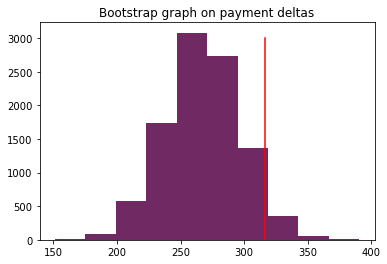

In [94]:
bootstrap_plt = plt.hist(bootstrap_means, color=COLOR_M)
plt.title('Bootstrap graph on payment deltas')

plt.plot([np.percentile(bootstrap_means, 95)] * 4, np.arange(0,3001,1000), color='red')

In [116]:
service_names_sig_max = service_name_avgs[service_name_cnts > 1000] >= np.percentile(bootstrap_means, 95)
service_names_sig = service_names_sig_max
service_names_sig = service_names_sig[service_names_sig == True].index
service_name_avgs[service_names_sig]

service_name
Illegal Dumping    326.102780
Encampment         369.137476
Name: payment_diff, dtype: float64

In [97]:
sig_rows = valid_df.service_name.apply(lambda x: x in service_names_sig)
sig_df = valid_df[sig_rows.values].reset_index(drop=True)
sig_df.dropna(inplace=True)
sig_df.case_age_days = sig_df.case_age_days.astype(int)

prio_high_cutoff = np.percentile(bootstrap_means, 95)#service_name_avgs.values, 95)
sig_df['payment_prio'] = sig_df.payment_diff.apply(categorize_differences, args=(0,prio_high_cutoff))

,service_request_id,zip,service_name,lat,lng,comm_plan_name,case_age_days,pole,payment_before,payment_after,payment_diff,payment_prio
0,3570191,92103.0,Encampment,32.750229,-117.161072,Uptown,6,2,9675,11324,1649,High Priority
1,3391425,92101.0,Illegal Dumping,32.711060,-117.162880,Downtown,2,5,134337,136233,1896,High Priority
2,2978854,92101.0,Encampment,32.717426,-117.157364,Downtown,243,13,30717,47610,16893,High Priority
3,3373094,92101.0,Encampment,32.721466,-117.159103,Downtown,2,5,14470,9619,-4851,Low Priority
4,3262632,92101.0,Encampment,32.719654,-117.162926,Downtown,7,9,19150,17478,-1672,Low Priority
...,...,...,...,...,...,...,...,...,...,...,...,...
6332,3322414,92103.0,Encampment,32.740887,-117.160667,Uptown,0,9,30672,32620,1948,High Priority
6333,3026542,92101.0,Encampment,32.720943,-117.161804,Downtown,188,7,5427,5797,370,High Priority
6334,3411044,92101.0,Encampment,32.714695,-117.157639,Downtown,0,19,46718,42058,-4660,Low Priority
6335,3417536,92101.0,Illegal Dumping,32.708912,-117.160103,Downtown,4,2,1640,2000,360,High Priority


In [98]:
sig_df.case_age_days.describe()

count    5424.000000
mean       13.365597
std        27.454339
min         0.000000
25%         2.000000
50%         5.000000
75%        12.000000
max       368.000000
Name: case_age_days, dtype: float64

In [110]:
case_age_graph_style = {
    'kind':'scatter',
    'figsize':(6,6),
    'fontsize':11,
    'color':COLOR_M,
    'title':'Payment Deltas compared to Days to Resolution'
}

<AxesSubplot:title={'center':'Payment Deltas compared to Days to Resolution'}, xlabel='case_age_days', ylabel='payment_diff'>

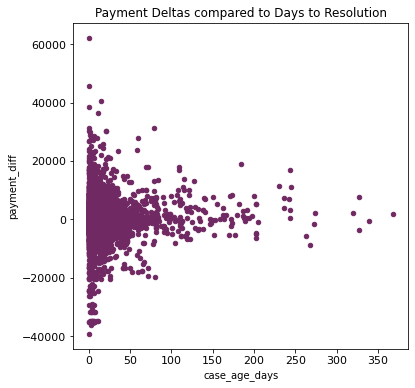

In [111]:
sig_df.plot(x='case_age_days', y='payment_diff', **case_age_graph_style)

In [48]:
col_names = np.concatenate((np.unique(valid_df.service_name), np.unique(valid_df.pole.astype(int)), ['payment_before']))
valid_df['payment_prio'] = valid_df.payment_diff.apply(categorize_differences, args=(0,prio_high_cutoff))

In [49]:
valid_df.to_csv('data/valid_df.csv', encoding='utf-8', index=False)

In [118]:
valid_df = pd.read_csv('data/valid_df.csv')
valid_df

,service_request_id,zip,service_name,lat,lng,comm_plan_name,case_age_days,pole,payment_before,payment_after,payment_diff,payment_prio
0,3312052,92103.0,Graffiti,32.747627,-117.160431,Uptown,66.0,4,9297,12482,3185,High Priority
1,3570191,92103.0,Encampment,32.750229,-117.161072,Uptown,6.0,2,9675,11324,1649,High Priority
2,3334866,NaN,Missed Collection,32.748714,-117.153351,Uptown,50.0,5,34074,32625,-1449,Low Priority
3,3320542,92103.0,Graffiti,32.749813,-117.160576,Uptown,61.0,4,16787,21819,5032,High Priority
4,3351846,NaN,Shared Mobility Device,32.712322,-117.163857,Downtown,0.0,1,5019,5930,911,High Priority
...,...,...,...,...,...,...,...,...,...,...,...,...
30400,3409962,NaN,Shared Mobility Device,32.719467,-117.167786,Downtown,0.0,6,38181,33631,-4550,Low Priority
30401,3408880,NaN,Environmental Services Code Compliance,32.710720,-117.157524,Downtown,31.0,11,72752,65995,-6757,Low Priority
30402,3399534,NaN,Shared Mobility Device,32.710682,-117.159309,Downtown,0.0,10,152497,153396,899,High Priority
30403,3589621,92103.0,Environmental Services Code Compliance,32.740582,-117.178490,Uptown,3.0,1,900,1275,375,High Priority


In [119]:
#Training using all categories

X = valid_df.loc[:,['service_name', 'pole', 'payment_before']]
one_hotter = OneHotEncoder(sparse=False)
normer = StandardScaler()
sig_transformer = ColumnTransformer([('categories', one_hotter, ['service_name', 'pole']),
                                     ('numerical', normer, ['payment_before'])])
X = pd.DataFrame(sig_transformer.fit_transform(X), columns=col_names)
y = valid_df['payment_prio']

In [120]:
#test and rest sets
X_rest,X_test,y_rest,y_test = train_test_split(X,y, test_size=0.3, random_state=32)
#train and validation sets made from rest set

In [121]:
X_train,X_val,y_train,y_val = train_test_split(X_rest,y_rest, test_size=0.2, random_state=32)

In [122]:
log_reg_mdl = LogisticRegression(max_iter=1000)
nb_mdl = GaussianNB()
knn_mdl = KNeighborsClassifier()
ada_mdl = AdaBoostClassifier(n_estimators=100, 
                             learning_rate=1,
                             algorithm='SAMME',
                             random_state=32)
rf_mdl = RandomForestClassifier(n_estimators=100,
                                min_samples_split=2,
                                random_state= 32)

model_names = ['log_reg', 'naive_bayes', 'knn', 'ada_boost', 'random_forest']
model_arr = [log_reg_mdl, nb_mdl, knn_mdl, ada_mdl, rf_mdl]
model_preds = {}

for i in np.arange(len(model_arr)):
    model = model_arr[i]
    name = model_names[i]
    model.fit(X_train, y_train)
    model_pred = model.predict(X_val)
    model_preds[name] = model_pred
    
    print(classification_report(y_val,model_pred, target_names=['High', 'Low']))

D:\anaconda\envs\parking\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str', 'str_']. An error will be raised in 1.2.
  warnings.warn(
D:\anaconda\envs\parking\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str', 'str_']. An error will be raised in 1.2.
  warnings.warn(


              precision    recall  f1-score   support

        High       0.52      0.39      0.44      2046
         Low       0.54      0.66      0.60      2211

    accuracy                           0.53      4257
   macro avg       0.53      0.53      0.52      4257
weighted avg       0.53      0.53      0.52      4257



D:\anaconda\envs\parking\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str', 'str_']. An error will be raised in 1.2.
  warnings.warn(
D:\anaconda\envs\parking\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str', 'str_']. An error will be raised in 1.2.
  warnings.warn(


              precision    recall  f1-score   support

        High       0.50      0.04      0.08      2046
         Low       0.52      0.96      0.68      2211

    accuracy                           0.52      4257
   macro avg       0.51      0.50      0.38      4257
weighted avg       0.51      0.52      0.39      4257



D:\anaconda\envs\parking\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str', 'str_']. An error will be raised in 1.2.
  warnings.warn(
D:\anaconda\envs\parking\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str', 'str_']. An error will be raised in 1.2.
  warnings.warn(
D:\anaconda\envs\parking\lib\site-packages\sklearn\neighbors\_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
 

              precision    recall  f1-score   support

        High       0.56      0.54      0.55      2046
         Low       0.59      0.61      0.60      2211

    accuracy                           0.58      4257
   macro avg       0.57      0.57      0.57      4257
weighted avg       0.57      0.58      0.57      4257



D:\anaconda\envs\parking\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str', 'str_']. An error will be raised in 1.2.
  warnings.warn(
D:\anaconda\envs\parking\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str', 'str_']. An error will be raised in 1.2.
  warnings.warn(


              precision    recall  f1-score   support

        High       0.59      0.11      0.19      2046
         Low       0.53      0.93      0.67      2211

    accuracy                           0.54      4257
   macro avg       0.56      0.52      0.43      4257
weighted avg       0.56      0.54      0.44      4257



D:\anaconda\envs\parking\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str', 'str_']. An error will be raised in 1.2.
  warnings.warn(
D:\anaconda\envs\parking\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str', 'str_']. An error will be raised in 1.2.
  warnings.warn(


              precision    recall  f1-score   support

        High       0.58      0.57      0.57      2046
         Low       0.61      0.62      0.61      2211

    accuracy                           0.59      4257
   macro avg       0.59      0.59      0.59      4257
weighted avg       0.59      0.59      0.59      4257



In [123]:
joblib.dump(rf_mdl, 'forest.pkl')

['forest.pkl']

In [56]:
def categorize_baseline(val, decision_map):
    try:
        return decision_map[val]
    except KeyError:
        return "NaN Priority"
baseline_decider_map = service_name_avgs.apply(categorize_differences, args=(0, prio_high_cutoff))

baseline_preds = valid_cleared.reset_index().service_name.apply(categorize_baseline, args=(baseline_decider_map,))

In [57]:
baseline_preds_val = pd.merge(X_val, baseline_preds, how='left',left_index=True, right_index=True).service_name

In [58]:
print(classification_report(y_val,baseline_preds_val, target_names=['High', 'Low']))

              precision    recall  f1-score   support

        High       0.50      0.38      0.43      2046
         Low       0.53      0.64      0.58      2211

    accuracy                           0.52      4257
   macro avg       0.51      0.51      0.51      4257
weighted avg       0.51      0.52      0.51      4257



In [59]:
model_df = pd.DataFrame(model_preds)
model_df['baseline'] = baseline_preds

In [60]:
pd.merge(valid_df, model_df, left_index=True, right_index=True).to_csv('predictions/train_model_preds.csv', encoding='utf-8', index=True)